In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
periodo = 365
USE_CUMSUM = True
year_list = ['2017','2018','2019','2022','2023']

lista_servicios_salud = [9,10,11,12,13,14]
etiquetas_servicios_salud = ['Met. Norte', 'Met. Occidente','Met. Central',
    'Met. Oriente', 'Met. Sur', 'Met. Suroriente']

In [3]:
duckdb.sql("""select GLOSATIPOESTABLECIMIENTO 
, IDCausa
, sum(Menores_1)  as Menores_1
, sum(De_1_a_4)  as De_1_a_4
, sum(De_5_a_14)  as De_5_a_14
, sum(De_15_a_64)   as De_15_a_64
, sum(De_65_y_mas) as De_65_y_mas
, sum(Total)  as atenciones
FROM datos_urgencia_consolidados.parquet
where IdCausa in (7)
and CodigoDependencia in (9,10,11,12,13,14)
group by  GLOSATIPOESTABLECIMIENTO, IdCausa
having atenciones >0
order by  GLOSATIPOESTABLECIMIENTO, IdCausa
""").df()
#TOTAL sin filtrar por codigo dependencia null  147107

,GLOSATIPOESTABLECIMIENTO,IdCausa,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,atenciones
0,Hospital,7,36301.0,27354.0,9411.0,28092.0,44607.0,145765.0
1,SAR,7,148.0,114.0,74.0,430.0,576.0,1342.0


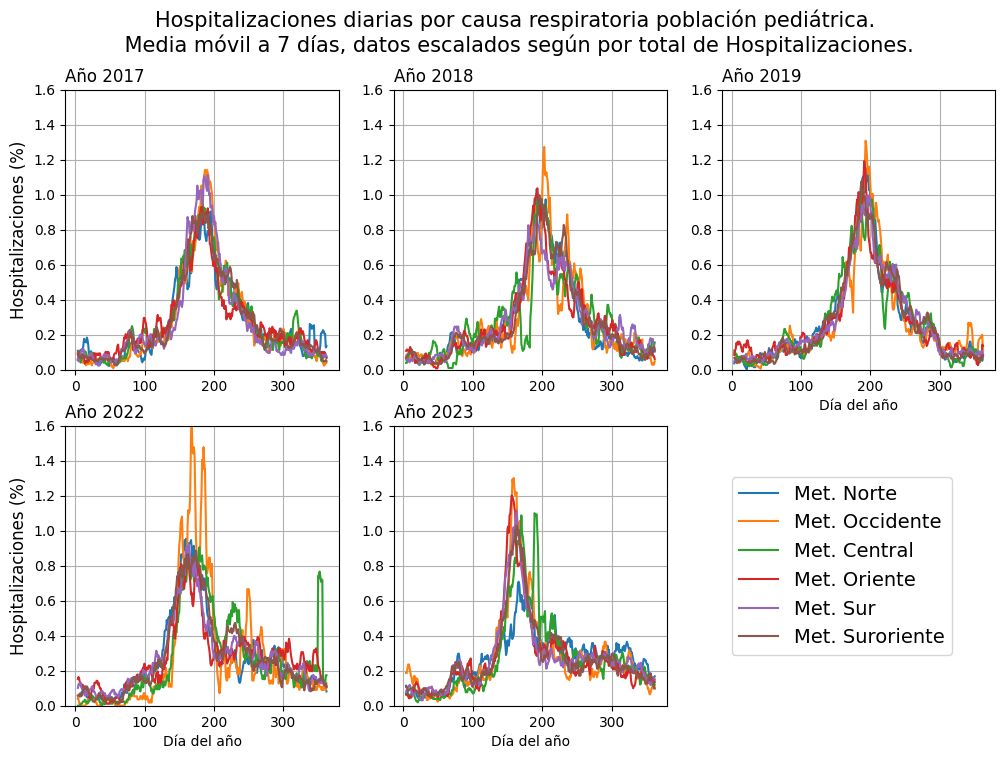

In [4]:
# ILUSTRACIÓN 15: Hospitalizaciones por causa respiratoria poblacion pediátrica RM

for k, year_name in enumerate(year_list):
    year_figure = year_list[k]
    
    df = duckdb.sql("""
    select 
          year(strptime(fecha, '%d/%m/%Y')) as year
        , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
        , CodigoDependencia
        , 'Todos' as TipoEstablecimiento
        , sum(Menores_1) as Menores_1
        , sum(De_1_a_4) as De_1_a_4
        , sum(De_5_a_14) as De_5_a_14
        , sum(De_15_a_64) as De_15_a_64
        , sum(De_65_y_mas) as De_65_y_mas
        , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) as pediatricos
        , sum(De_15_a_64) + sum(De_65_y_mas) as adultos
        , sum(Total) as atenciones
    FROM datos_urgencia_consolidados.parquet
    where IdCausa in (7)
    and CodigoDependencia in (9,10,11,12,13,14)
    and fecha like '%""" + year_figure + """'
    group by year, CodigoDependencia, nrodia, TipoEstablecimiento
    order by year, CodigoDependencia, TipoEstablecimiento, nrodia
    """).df()
    
    if k==0:
        fig = plt.figure(figsize = (12,8))
    fig.suptitle('Hospitalizaciones diarias por causa respiratoria población pediátrica.\n Media móvil a 7 días, datos escalados según por total de Hospitalizaciones.', fontsize=15)


    ax = fig.add_subplot(2,3,k+1) 
    targets = ["pediatricos"]
    
    etiquetas_servicios_salud = ['Met. Norte', 'Met. Occidente','Met. Central',
    'Met. Oriente', 'Met. Sur', 'Met. Suroriente']
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for servicio_salud in [9,10,11,12,13,14]:
        for column in targets:
            filtro_filas = (df["CodigoDependencia"]==servicio_salud) #& (df["TipoEstablecimiento"]== 'Hospital')
            plt.plot(df.loc[filtro_filas,'nrodia'],100*df.loc[filtro_filas,column].rolling(7,center=True).mean()/float(sum(df.loc[filtro_filas,column]))) # c = color)
            #plt.plot(df.loc[filtro_filas,'nrodia'],df.loc[filtro_filas,column].rolling(7,center=True).mean()) # c = color)
    ax.grid()
    ax.set_title('Año ' + year_figure, fontsize = 12,loc='left')
    if k in (2,3,4):
        ax.set_xlabel('Día del año', fontsize = 10)
    if k in (0,3):
        ax.set_ylabel('Hospitalizaciones (%)', fontsize = 12)
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=1.6)
#show legend in last plot space
ax = fig.add_subplot(2,3,6) 
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for servicio_salud in [9,10,11,12,13,14]:
   plt.plot(range(1),range(1))
ax.legend(etiquetas_servicios_salud,loc='center left',fontsize = 14 )
ax.axis('off')


plt.savefig('fig15_hospitalizaciones_pediatricas_RM.png', bbox_inches='tight')

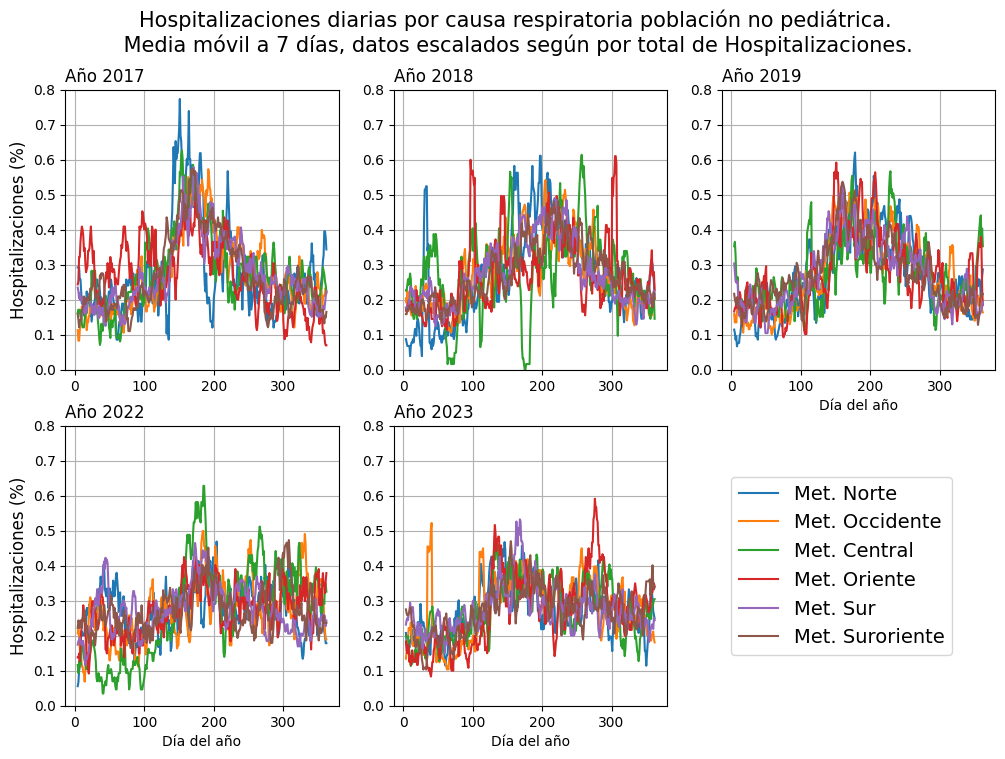

In [5]:
# ILUSTRACIÓN 16: Hospitalizaciones por causa respiratoria poblacion no pediátrica RM

for k, year_name in enumerate(year_list):
    year_figure = year_list[k]
    
    df = duckdb.sql("""
    select 
          year(strptime(fecha, '%d/%m/%Y')) as year
        , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
        , CodigoDependencia
        , 'Todos' as TipoEstablecimiento
        , sum(Menores_1) as Menores_1
        , sum(De_1_a_4) as De_1_a_4
        , sum(De_5_a_14) as De_5_a_14
        , sum(De_15_a_64) as De_15_a_64
        , sum(De_65_y_mas) as De_65_y_mas
        , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) as pediatricos
        , sum(De_15_a_64) + sum(De_65_y_mas) as adultos
        , sum(Total) as atenciones
    FROM datos_urgencia_consolidados.parquet
    where IdCausa in (7)
    and CodigoDependencia in (9,10,11,12,13,14)
    and fecha like '%""" + year_figure + """'
    group by year, CodigoDependencia, nrodia, TipoEstablecimiento
    order by year, CodigoDependencia, TipoEstablecimiento, nrodia
    """).df()
    

    if k==0:
        fig = plt.figure(figsize = (12,8))
    fig.suptitle('Hospitalizaciones diarias por causa respiratoria población no pediátrica.\n Media móvil a 7 días, datos escalados según por total de Hospitalizaciones.', fontsize=15)


    ax = fig.add_subplot(2,3,k+1) 
    targets = ["adultos"]
    
    etiquetas_servicios_salud = ['Met. Norte', 'Met. Occidente','Met. Central',
    'Met. Oriente', 'Met. Sur', 'Met. Suroriente']
    
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for servicio_salud in [9,10,11,12,13,14]:
        for column in targets:
            filtro_filas = (df["CodigoDependencia"]==servicio_salud) #& (df["TipoEstablecimiento"]== 'Hospital')
            plt.plot(df.loc[filtro_filas,'nrodia'],100*df.loc[filtro_filas,column].rolling(7,center=True).mean()/float(sum(df.loc[filtro_filas,column]))) # c = color)
            #plt.plot(df.loc[filtro_filas,'nrodia'],df.loc[filtro_filas,column].rolling(7,center=True).mean()) # c = color)
    ax.grid()
    ax.set_title('Año ' + year_figure, fontsize = 12,loc='left')
    if k in (2,3,4):
        ax.set_xlabel('Día del año', fontsize = 10)
    if k in (0,3):
        ax.set_ylabel('Hospitalizaciones (%)', fontsize = 12)
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.8)
    
#show legend in last plot space
ax = fig.add_subplot(2,3,6) 
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for servicio_salud in [9,10,11,12,13,14]:
   plt.plot(range(1),range(1))
ax.legend(etiquetas_servicios_salud,loc='center left',fontsize = 14 )
ax.axis('off')


plt.savefig('fig16_hospitalizaciones_no_pediatricas_RM.png', bbox_inches='tight')
